# LightGBM Using Serverless Functions

```mlrun``` is an open-source Python package that provides a framework for running machine learning tasks transparently in multiple, scalable, runtime environments.  ```mlrun``` provides tracking of code, metadata, inputs, outputs and the results of machine learning pipelines. 

In this notebook we'll take a look at using ```mlrun```, ```nuclio``` and KubeFlow to assemble a data acquisition and model training pipeline and deploy it as a nuclio serverless function with an API endpoint for testing.  The focus here is on how all the components interact, and less on the boosting model and its optimization for the Higgs dataset.

1. [Setup](#Setup)
2. [Nuclio code section](#nuclio-code-section)
     * [nuclio's ignore notation](#nuclio's%20_**ignore**_%20notation)
     * [function dependencies](#function-dependencies)
     * [utiltiy functions](#utilities)
3. [Pipeline methods](#pipeline-methods)
     * [acquire](#acquire)
     * [split](#split)
     * [train](#train)
     * [test](#test)
4. [Testing locally](#testing)
5. [Create a deployment image](#image)
6. [Create a KubeFlow Pipeline](#pipeline)
7. [Compile the pipeline](#compile-the-pipeline)

## Setup

The following will reinstall the latest development version of ```mlrun```:

In [25]:
# !pip uninstall -y mlrun
# !pip install git+https://github.com/mlrun/mlrun.git@development

Install the KubeFlow pipelines package ```kfp```. For more information see the **[KubeFlow documentation on nuclio](https://www.kubeflow.org/docs/components/misc/nuclio/)** and  **[Kubeflow pipelines and nuclio](https://github.com/kubeflow/pipelines/tree/master/components/nuclio)**. For logging the estimated machine learning models we'll use ```joblib```'s [```dump``` and ```load```](https://joblib.readthedocs.io/en/latest/persistence.html#persistence).

In [3]:
# !pip install -U kfp joblib

<a id='nuclio-code-section'></a>
# Nuclio code section

### nuclio's _**ignore**_ notation

You'll write all the code that gets packaged for execution between the tags ```# nuclio: ignore```, meaning ignore all the code here and above, and ```# nuclio: end-code```, meaning ignore everything after this annotation.  Methods in this code section can be called separately if designed as such (```acquire```, ```split```, ```train```, ```test```), or as you'll discover below, they are most often "chained" together to form a pipeline where the output of one stage serves as the input to the next. The **[docs](https://github.com/nuclio/nuclio-jupyter#creating-and-debugging-functions-using-nuclio-magic)** also suggest another approach: we can use ```# nuclio: start``` at the first relevant code cell instead of marking all the cells above with ```# nuclio: ignore```.

See the **[nuclio-jupyter](https://github.com/nuclio/nuclio-jupyter)** repo for further information on these and many other **[nuclio magic commands](https://github.com/nuclio/nuclio-jupyter#creating-and-debugging-functions-using-nuclio-magic)** that make it easy to transform a Jupyter notebook environment into a platform for developing production-quality, machine learning systems.

The ```nuclio-jupyter``` package provides methods for automatically generating and deploying nuclio serverless functions from code, repositories or Jupyter notebooks. **_If you have never run nuclio functions in your notebooks, please uncomment and run the following_**: ```!pip install nuclio-jupyter```

The following two lines **should be in the same cell** and mark the start of your mchine learning coding section:

In [4]:
# nuclio: ignore
import nuclio 

<a id='function-dependencies'></a>
### function dependencies

The installs made in the section **[Setup](#Setup)** covered the Jupyter environment within which this notebook runs.  However, we need to ensure that all the dependencies our nuclio function relies upon (such as ```matplotlib```, ```sklearn```, ```lightgbm```), will be available when that code is wrapped up into a nuclio function _**on some presently unknown runtime**_.   Within the nuclio code section we can ensure these dependencies get built into the function with the ```%nuclio cmd``` magic command.

In [5]:
# Define function dependencies
%nuclio cmd -c pip install -U matplotlib sklearn lightgbm kfp joblib pyarrow

We'll use a standard base image here, however the build step can be shortened by preparing images with pre-installed packages.

In [6]:
%nuclio config spec.build.baseImage = "python:3.6-jessie"

%nuclio: setting spec.build.baseImage to 'python:3.6-jessie'


In [7]:
from os import path, makedirs
import joblib
from io import BytesIO
from pathlib import Path
from urllib.request import urlretrieve
from typing import IO, AnyStr, TypeVar, Union

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split

import lightgbm as lgb
import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd
import numpy as np
from mlrun.artifacts import ChartArtifact, TableArtifact, PlotArtifact
from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem

In [8]:
import warnings
warnings.filterwarnings('ignore')

<a id='utilities'></a>
### utility functions

In [9]:
def get_context_table(ctxtable: MLCLientCtx):
    """Get table from context.
    
    Convenience function to retrieve a table via a blob.
    
    Args:
        ctxtable : The table saved in the context, 
            which needs to be deserialized.
        
    In this demonstration tables are stored in parquet format and passed
    between steps as blobs.  We could also pass folder or file names
    in the context, which may be faster.
    """
    blob = BytesIO(ctxtable.get())
    return pd.read_parquet(blob, engine='pyarrow')

In [10]:
def log_context_table(
    context: MLClientCtx,
    target: str, 
    name: str,
    table: pd.DataFrame
) -> None:
    """Log a table through the context.
    
    The table is written as a parquet file, and its target
    path is saved in the context.
    
    Args:
        context : The context.
        target : Location (folder) of our DataItem.
        name : Name of the object in the context.
        table  : The object we wish to store.
    """
    context.logger.info(f'writing {name}')
    pq.write_table(
        pa.Table.from_pandas(table),
        path.join(target, name))    
    context.log_artifact(name, target_path=path.join(target, name))

<a id=pipeline-methods></a>
### pipeline methods

These are the methods that will be chained together in a pipeline consisting of 4 steps: ```acquire```, ```split```, ```train```, ```test```.  

#### acquire

In the first step, we retrieve data in the form of a gzip archive from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php).  The file is saved as a parquet file and its location made available to the next step in the pipeline.



In [26]:
def acquire(
    context: MLClientCtx,
    archive_url: Union[str, Path, IO[AnyStr]],
    name: str = 'original',
    target_path: str = 'content',
    chunksize: int = 10_000
) -> None:
    """Open a file/object archive and save as a parquet file.
    
    Args:
        context : The context.
        archive_url : Any valid string path consistent with the path variable
            of pandas.read_csv. Includes, strings as file paths, as urls, 
            pathlib.Path objects, etc...
        header : Column names.
        target_path : Destination folder of table.
        chunksize : (default=0). Row size retrieved per iteration. If set
            will override any chunksize parameter in the read_csv_args
            parameter dict.
        kwargs:  A dict of parameters passed to pandas.read_csv and
            pyarrow.parquet.write_table. 
    """
    makedirs(target_path, exist_ok=True)
    context.logger.info('verified directories')
   
    # validate file name
    if not name.endswith('.parquet'):
        name += '.parquet'
    dest_path = path.join(target_path , name)
    
    # read and save
    context.logger.info(f'reading chunks from {archive_url}')
    for chunk in pd.read_csv(archive_url, chunksize=chunksize):
        pq.write_table(pa.Table.from_pandas(chunk), dest_path)    

    context.logger.info(f'saved table to {target_path}/{name}.parquet')
    context.log_artifact('raw_data_path', dest_path)

#### split

In this we generate labels and split into train-validation-test sets. The split tables are saved and logged.

In another project, this step may involve all of the data preprocessing steps like cleaning, resizing and augmenting images, prefiltering, or each stage in the preprocessing pipeline mayu have its own function.

In [27]:
def split(context: MLClientCtx,
          target_path: str = '',
          src: str = 'original',
          test_size: float = 0.1,
          train_val_split: float = 0.75,
          random_state: int = 1,
          sample: int = -1
) -> None:
    """Split raw data into train, validation and test sets.
    
    The file loaded at this stage is the raw data file that has been
    downloaded in a previous step (as a parquet file).  Here it is read
    and split into train, validation and test sets. The context is 
    updated with the target_path.
    
    Args:
    context : The `context`.
        target : Data storage location.
        src : (default 'original'). Location of original parquet file.
        test_size : (defaults=0.1) Set test set size, and leave the
            remainder for the second split into train and validation sets.
        train_val_split : (defaults=0.75) Once the test set has been
            removed the training set gets this proportion.
        random_state : (default 1). Seed used by the scikit-learn random
            number generator in the method train_test_split.
        sample : (default -1, all rows). Selects the first n rows, or
            select a sample. Check the balance of resulting sets if
            using the random sample option. Use this feature to explore the
            system or for debugging.
            
    Outputs
        The following outputs are saved at the target path:
        xtrain, ytrain (Tuple[pd.DataFrame, pd.DataFrame]): Training set.
        xvalid, yvalid (Tuple[pd.DataFrame, pd.DataFrame]): Validation set.
        xtest, ytest (Tuple[pd.DataFrame, pd.DataFrame]): Test set.
    """
    
    filepath = path.join(target_path, src)
    context.logger.info(f'reading original at {filepath}')
    
    # save only a sample, intended for debugging
    if (sample == -1) or (sample > 0):
        # get all rows, or contiguous sample starting at row 1.
        original = pq.read_table(filepath).to_pandas()
        labels = original.pop('labels')
        original = original.iloc[:sample, :]
        labels = labels.iloc[:sample]
    elif sample < 0:
        # grab a random sample
        original = pq.read_table(path.join(target_path, src)
                                ).to_pandas().sample(sample*-1)
        labels = original.pop('labels')
    else:
        # 0 is all that's left
        raise Exception("can't do much with 0 rows!, set sample to some \
            negative or positive number")
    
    context.logger.info(f'input {original.shape[0]} rows')
    
    # split twice to get training, validation and test sets.
    context.logger.info('splitting into train-valid-test data sets')
    x, xtest, y, ytest = train_test_split(original, 
                                          labels, 
                                          train_size=1-test_size, 
                                          test_size=test_size, 
                                          random_state=random_state)
    
    xtrain, xvalid, ytrain, yvalid = train_test_split(x, 
                                                      y, 
                                                      train_size=train_val_split, 
                                                      test_size=1-train_val_split,
                                                      random_state=random_state)    

    # save and log all the intermediate tables
    log_context_table(context, target_path, 'xtrain', xtrain)
    log_context_table(context, target_path, 'xvalid', xvalid)
    log_context_table(context, target_path, 'xtest', xtest)
    log_context_table(context, target_path, 'ytrain', pd.DataFrame({'labels':ytrain}))
    log_context_table(context, target_path, 'yvalid', pd.DataFrame({'labels':yvalid}))
    log_context_table(context, target_path, 'ytest', pd.DataFrame({'labels':ytest}))

#### train
We have used only 2 parameters for demonstration purposes, ```learning_rate``` and ```num_leaves```, see **[LightGBM Parameters](https://lightgbm.readthedocs.io/en/latest/Parameters.html#parameters)** for
more detail on the other parameters available and their default values.


In [28]:
def plot_validation(
    train_loss: np.ndarray, 
    valid_loss: np.ndarray, 
    title : str = "Classifier Training Results",
    xlabel: str = "boosting round",
    ylabel: str = "logloss",
    fmt: str = "png"):
    """Plot train and validation loss curves.
    
    These curves represent the training round losses from the training
    and validation sets. The actual type of loss curve depends on the 
    algorithm and selcted metrics.
    Args:
        train_loss : Vector of loss metric estimates for training set.
        valid_loss : Predictions given a test sample and an estimated model.
        title : Plot title.
        xlabel : X-axis label.
        ylabel: Y-axis label.
        fmt : The file image format (png, jpg, ...), and the saved file extension.
    """
    plt.plot(train_loss)
    plt.plot(valid_loss)
    plt.title('')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(['train', 'valid'])
    return plt.gcf()    

In [29]:
def train(context: MLClientCtx,
          xtrain: DataItem,
          ytrain: DataItem,
          xvalid: DataItem,
          yvalid: DataItem,
          silent: bool = False,
          random_state: int = 1,
          model_target: str = '',
          model_name: str = 'model.defaultname.pickle',
          losses_target = '',
          losses_name = '',
          num_leaves: int = 31,
          learning_rate: float = 0.1,
    ):
    """Train and save a LightGBM model.
    
    Args:
        context  : The function's context.
        xtrain : DataItem in context representing 2D array 
            (obs, features)  of features. 
        ytrain : DataItem in the context representing 
            ground-truth labels.
        xvalid, yvalid are a similarly defined validation set.
        silent : (default False) Show metrics for 
            training/validation steps.
        random_state : Random number generator seed.
        model_target : Destination path for model artifact.
        model_name : Destination name for model artifact.
        
    Also included for demonstration are a randomly selected sample
    of LightGBM parameters:
        num_leaves : (Default is 31).  In the LightGBM model
            controls complexity.  
        learning_rate : Step size at each iteration, constant.
    """
    lgb_clf = lgb.LGBMClassifier(num_leaves=num_leaves,
                                 learning_rate= learning_rate,
                                 objective='binary',
                                 metric='binary_logloss',
                                 random_state=random_state,
                                 silent=not silent)

    context.logger.info('read tables')
    xtrain = get_context_table(xtrain)
    ytrain = get_context_table(ytrain)
    xvalid = get_context_table(xvalid)
    yvalid = get_context_table(yvalid)
    
    context.logger.info(f'training input {xtrain.shape[0]} rows')
    context.logger.info('starting train')
    eval_results = dict()
    eval_result = lgb.record_evaluation(eval_results)
    lgb_clf.fit(xtrain, 
                ytrain,
                eval_set=[(xvalid, yvalid), (xtrain, ytrain)],
                eval_names=['valid', 'train'],
                callbacks=[eval_result],
                verbose=silent)
    
    # extract the training and validation losses, plot and save data as a TableArtifact.
    train_logloss = np.asarray(eval_results['train']['binary_logloss'], dtype=np.float)
    valid_logloss = np.asarray(eval_results['valid']['binary_logloss'], dtype=np.float)
    losses_path = path.join(losses_target, losses_name)
    train_losses = pd.DataFrame({'train':train_logloss, 'valid': valid_logloss})
    context.log_artifact(TableArtifact('train_losses', df=train_losses, target_path=losses_path))
    fig = plot_validation(train_logloss, valid_logloss)
    context.log_artifact(PlotArtifact('classifier-training', body=fig))

    # pickle/serialize the model at target
    if not path.isdir(model_target):
        makedirs(model_target)
    file_path = path.join(model_target, model_name)
    joblib.dump(lgb_clf, open(file_path, 'wb'))
    context.log_artifact('model_dir',
                         target_path=model_target,
                         labels={'framework': 'lgbmboost'}) 

#### test

In addition to a ```model```, the first step (```load```) created test features and labels we can retrieve and pass on to the ```test``` method.  An ROC plot is built using the test set and make it available for display.

In [15]:
def plot_roc(ytest, ypred, fmt="png"):
    """Plot an ROC curve.
    
    Args:
        ytest (array-like) : Ground-truth labels.
        ypred (array-like) : Predictions given a test sample and 
            an estimated model.
        fmt (str) : The file image format (png, jpg, ...), and 
            the saved file extension.
    """
    fpr_xg, tpr_xg, _ = roc_curve(ytest, ypred)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_xg, tpr_xg, label='xgboost')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('roc curve - lightgbm')
    plt.legend(loc='best')
    return plt.gcf()    

In [16]:
def test(context: MLClientCtx,
         model_dir: str, 
         xtest: DataItem,
         ytest: DataItem,
         fmt:str = 'png', 
         target_path:str = '',
         model_name: str = 'lightgbm.model.pickle'):
    """Load model and predict.
    
    Arg:
        context (MLClientCtx) : The `context`.
        model_dir (DataItem) : Contains the model's path.
        xtest (DataItem) : (NxM), N is sample size and M the number of features
            of the test set.
        ytest (DataItem) : 1D (N,1) Array of ground-truth labels,
        fmt (str) : (Default is 'png'). The image format.
        target_path (str) : location of the 
        
    """
    modelpath = path.join(str(model_dir), model_name)
    context.logger.info(modelpath)
    lgbm_model = joblib.load(
        open(modelpath, 'rb'))
    
    xtest = get_context_table(xtest)
    ytest = get_context_table(ytest)
    context.logger.info(f'test input {xtest.shape[0]} rows')
    
    ypred = lgbm_model.predict(xtest)
    
    acc = accuracy_score(ytest, ypred)
    
    context.logger.info(f'type: {type(acc)}   value: {acc}')
    context.log_result('accuracy', float(acc))
    
    fig = plot_roc(ytest, ypred, fmt)
    
    context.log_artifact(PlotArtifact('roc-curve', body=fig))    

#### **end of nuclio function definition**

In [17]:
# nuclio: end-code

<a id="testing"></a>
## Testing locally

The function can be run locally and debugged/tested before deployment:

In [18]:
from mlrun import code_to_function, mount_v3io, new_function, new_model_server, mlconf
# for local DB path use 'User/mlrun' instead 
%env MLRUN_DBPATH=/User/mlrun
mlconf.dbpath = '/User/mlrun'

env: MLRUN_DBPATH=/User/mlrun


In [19]:
workflow = new_function()

acquire_run = workflow.run(
    name='acquire_remote_data',
    handler=acquire, 
    params={
        'archive_url': "/User/projects/lightgbm/data/HIGGS.csv.gz",
        'name': 'original',
        'target_path': '/User/projects/lightgbm/data/raw'})

[mlrun] 2019-12-17 17:21:10,576 starting run acquire_remote_data uid=018bb4d5bfb94512a041ee364f1ffa4c  -> /User/mlrun
[mlrun] 2019-12-17 17:21:10,840 verified directories
[mlrun] 2019-12-17 17:21:10,840 reading chunks from /User/projects/lightgbm/data/HIGGS.csv.gz
[mlrun] 2019-12-17 17:24:40,169 saved table to /User/projects/lightgbm/data/raw/original.parquet.parquet



uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...1ffa4c,0,Dec 17 17:21:10,completed,acquire_remote_data,repo=https://github.com/yjb-ds/demos.gitcommit=2b86f04a5e18aa5ea9c9857f5c7b88b736088bd2kind=handlerowner=adminhost=jupyter-qlqrqnzi25-vogv2-79db4f79d-fr4p9,,archive_url=/User/projects/lightgbm/data/HIGGS.csv.gzname=originaltarget_path=/User/projects/lightgbm/data/raw,,raw_data_path


type result.show() to see detailed results/progress or use CLI:
!mlrun get run --uid 018bb4d5bfb94512a041ee364f1ffa4c 
[mlrun] 2019-12-17 17:24:40,288 run executed, status=completed


In [20]:
split_run = workflow.run(
    name='split_data',
    handler=split, 
    params={
        'target_path': '/User/projects/lightgbm/data/raw',
        'sample': -3_000
    })

[mlrun] 2019-12-17 17:24:40,294 starting run split_data uid=befe66e929f44e19b16d32fd24ee2ee8  -> /User/mlrun
[mlrun] 2019-12-17 17:24:40,467 reading original at /User/projects/lightgbm/data/raw/original
[mlrun] 2019-12-17 17:24:43,310 input 3000 rows
[mlrun] 2019-12-17 17:24:43,310 splitting into train-valid-test data sets
[mlrun] 2019-12-17 17:24:43,314 writing xtrain
[mlrun] 2019-12-17 17:24:43,372 writing xvalid
[mlrun] 2019-12-17 17:24:43,418 writing xtest
[mlrun] 2019-12-17 17:24:43,454 writing ytrain
[mlrun] 2019-12-17 17:24:43,673 writing yvalid
[mlrun] 2019-12-17 17:24:43,700 writing ytest



uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...ee2ee8,0,Dec 17 17:24:40,completed,split_data,repo=https://github.com/yjb-ds/demos.gitcommit=2b86f04a5e18aa5ea9c9857f5c7b88b736088bd2kind=handlerowner=adminhost=jupyter-qlqrqnzi25-vogv2-79db4f79d-fr4p9,,target_path=/User/projects/lightgbm/data/rawsample=-3000,,xtrainxvalidxtestytrainyvalidytest


type result.show() to see detailed results/progress or use CLI:
!mlrun get run --uid befe66e929f44e19b16d32fd24ee2ee8 
[mlrun] 2019-12-17 17:24:43,760 run executed, status=completed


[mlrun] 2019-12-17 17:28:12,480 starting run train_model uid=6c951f878d63414e8be34d27cf6e503c  -> /User/mlrun
[mlrun] 2019-12-17 17:28:12,654 read tables
[mlrun] 2019-12-17 17:28:12,689 training input 2025 rows
[mlrun] 2019-12-17 17:28:12,689 starting train



uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...6e503c,0,Dec 17 17:28:12,completed,train_model,repo=https://github.com/yjb-ds/demos.gitcommit=2b86f04a5e18aa5ea9c9857f5c7b88b736088bd2kind=handlerowner=adminhost=jupyter-qlqrqnzi25-vogv2-79db4f79d-fr4p9,xtrainytrainxvalidyvalid,losses_target=/User/projects/lightgbm/resultslosses_name=train_valid_losses.csvmodel_target=/User/projects/lightgbm/modelsmodel_name=lightgbm.model.pickle,,train_lossesclassifier-training.htmlmodel_dir


type result.show() to see detailed results/progress or use CLI:
!mlrun get run --uid 6c951f878d63414e8be34d27cf6e503c 
[mlrun] 2019-12-17 17:28:17,694 run executed, status=completed


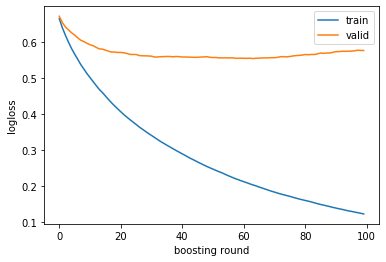

In [21]:
train_run = workflow.run(
    name = 'train_model',
    handler=train,
    inputs={'xtrain': split_run.output('xtrain'),
            'ytrain': split_run.output('ytrain'),
            'xvalid': split_run.output('xvalid'),
            'yvalid': split_run.output('yvalid')},
    params={'losses_target': '/User/projects/lightgbm/results',
            'losses_name': 'train_valid_losses.csv',
            'model_target': '/User/projects/lightgbm/models',
            'model_name': 'lightgbm.model.pickle'})

[mlrun] 2019-12-17 17:29:54,432 starting run test_model uid=824be95cba9246b4a30e7982892fe79a  -> /User/mlrun
[mlrun] 2019-12-17 17:29:54,593 /User/projects/lightgbm/models/lightgbm.model.pickle
[mlrun] 2019-12-17 17:29:54,676 test input 300 rows
[mlrun] 2019-12-17 17:29:54,697 type: <class 'numpy.float64'>   value: 0.6766666666666666



uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...2fe79a,0,Dec 17 17:29:54,completed,test_model,repo=https://github.com/yjb-ds/demos.gitcommit=2b86f04a5e18aa5ea9c9857f5c7b88b736088bd2kind=handlerowner=adminhost=jupyter-qlqrqnzi25-vogv2-79db4f79d-fr4p9,model_dirxtestytest,model_name=lightgbm.model.pickle,accuracy=0.6766666666666666,roc-curve.html


type result.show() to see detailed results/progress or use CLI:
!mlrun get run --uid 824be95cba9246b4a30e7982892fe79a 
[mlrun] 2019-12-17 17:29:54,869 run executed, status=completed


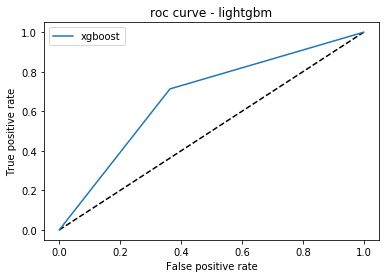

In [22]:
test_run = workflow.run(
    name = 'test_model',
    handler=test,
    inputs={'model_dir': train_run.output('model_dir'),
            'xtest': split_run.output('xtest'),
            'ytest': split_run.output('ytest')},
    params={'model_name': 'lightgbm.model.pickle'})

<a id="image"></a>
### Create a deployment image

Once debugged you can create a reusable image, and then deploy it for testing.

In [31]:
lgbm_job = code_to_function(runtime='job').apply(mount_v3io())
# # prepare an image from the dependencies, so we wont need to build the image every run 
lgbm_job.build(image='mlrun/mlrunlgb:latest')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-4b75265cd12e>", line 1, in <module>
    lgbm_job = code_to_function(runtime='job').apply(mount_v3io())
  File "/User/.pythonlibs/lib/python3.6/site-packages/mlrun/run.py", line 326, in code_to_function
    name, spec, code = build_file(filename, name=name, handler=handler)
  File "/conda/lib/python3.6/site-packages/nuclio/build.py", line 56, in build_file
    config, code = build_notebook(filename, dont_embed, tag)
  File "/conda/lib/python3.6/site-packages/nuclio/build.py", line 165, in build_notebook
    out = run(cmd, env=env, stdout=PIPE, stderr=PIPE)
  File "/conda/lib/python3.6/subprocess.py", line 425, in run
    stdout, stderr = process.communicate(input, timeout=timeout)
  File "/conda/lib/python3.6/subprocess.py", line 863, in communicate
    stdout, stderr = self

KeyboardInterrupt: 

While debugging, and **after you have run build at least once**, you can comment out the last cell so that the build process isn't started needlessly.  The code can be injected into the job using the following line:

In [ ]:
# lgbm_job.with_code()

<a id="pipeline"></a>
### Create a KubeFlow Pipeline from our functions

Our pipeline will consist of two instead of three steps, ```load``` and ```train```.  We'll drop the ```test```
here since at the end of this deployment we can test the system with API requests.

For complete details on KubeFlow Pipelines please refer to the following docs:
1. [KubeFlow pipelines](https://www.kubeflow.org/docs/pipelines/).
2. [kfp.dsl Python package](https://kubeflow-pipelines.readthedocs.io/en/latest/source/kfp.dsl.html#module-kfp.dsl).

Please note, the model server file name in the **```new_model_server```** function call below should not have any spaces in it.

In [ ]:
import kfp
from kfp import dsl

In [ ]:
@dsl.pipeline(
    name='LGBMClassifier training pipeline',
    description='Shows how to use mlrun/kfp.'
)
def lgbm_pipeline(
   learning_rate = [0.01, 0.1, 0.3], num_leaves = [31, 127, 255]
):

    acquire_step = lgbm_job.as_step(
            name='acquire_remote_data',
            handler='acquire',
            params={
                'archive_url': "/User/projects/lightgbm/data/HIGGS.csv.gz",
                'name': 'original',
                'target_path': '/User/projects/lightgbm/data/raw'},
            outputs=['original'], 
            out_path='/User/projects/lightgbm/data/raw').apply(mount_v3io())
    
    split_step = lgbm_job.as_step(
            name='split_data',
            handler='split',
            params={
                'sample': -3_000,
                'target_path': '/User/projects/lightgbm/data/raw'},
            outputs=['xtrain', 'ytrain', 'xvalid', 'yvalid', 'xtest', 'ytest'], 
            out_path='/User/projects/lightgbm/data/raw').apply(mount_v3io())

    train_step = lgbm_job.as_step(
            name='train_model', 
            handler='split',
            params = {
                'losses_target': '/User/projects/lightgbm/results',
                'losses_name': 'train_valid_losses.csv',
                'model_target': '/User/projects/lightgbm/models',
                'model_name': 'lightgbm.model.pickle'
                },
            hyperparams = {
                'learning_rate': learning_rate,
                'num_leaves': num_leaves},
            inputs = {'xtrain': load_step.outputs['xtrain'],
                      'ytrain':load_step.outputs['ytrain'],
                      'xvalid':load_step.outputs['xvalid'],
                      'yvalid':load_step.outputs['yvalid']}, 
            outputs=['model'],
            out_path= '/User/projects/lightgbm/models').apply(mount_v3io())

    test_step = lgbm_job.as_step(
        name='test_model',
        handler='test',
        selector='max.accuracy',
        inputs = {'model_dir': train_step.outputs['model_dir'],
                  'xtest': load_step.outputs['xtest'],
                  'ytest':load_step.outputs['ytest']}, 
        params = {
            'model_name': 'lightgbm.model.pickle'
        },
        out_path='/User/projects/lightgbm/results').apply(mount_v3io())
    
    # define a nuclio-serving function, generated from a notebook file
    srvfn = new_model_server(
        'higgs-serving', 
        model_class='LGBoostModel', 
        filename='model-server.ipynb')
    
    # deploy the model serving function with inputs from the training stage
    deploy = srvfn.with_v3io('User', '~/').deploy_step(project='refactor-demos', 
                                                       models={'lgbm_v5_joblib': train_step.outputs['model']})

<a id="compile the pipeline"></a>
### compile the pipeline

We can compile our KubeFlow pipeline and produce a yaml description of the pipeline worflow:

In [30]:
kfp.compiler.Compiler().compile(lgbm_pipeline, 'mlrunpipe.yaml')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-4fcdcf0fa24d>", line 1, in <module>
    kfp.compiler.Compiler().compile(lgbm_pipeline, 'mlrunpipe.yaml')
NameError: name 'kfp' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/conda/lib/python3.6/site-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/conda/lib/python3.6/site-packages/I

NameError: name 'kfp' is not defined

In [ ]:
client = kfp.Client(namespace='default-tenant')

In [ ]:
arguments = {
    'learning_rate': [0.01, 0.1, 0.30],
    'num_leaves': [31, 255]}

run_result = client.create_run_from_pipeline_func(
    lgbm_pipeline, 
    arguments, 
    run_name='lgbm 7',
    experiment_name='lgbm_parquet')